In [1]:
!pip -q install --upgrade --no-cache-dir gdown

In [2]:
#download masks_patches_filtered_train.zip
!gdown 1-EkqDklIT6z2FpxuHk7RcSUFQv3C0pG3

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-EkqDklIT6z2FpxuHk7RcSUFQv3C0pG3
From (redirected): https://drive.google.com/uc?id=1-EkqDklIT6z2FpxuHk7RcSUFQv3C0pG3&confirm=t&uuid=d6e05cce-83df-4fa3-aaf7-ce9951378291
To: /kaggle/working/masks_patches_filtered_train.zip
100%|███████████████████████████████████████| 18.9M/18.9M [00:00<00:00, 124MB/s]


In [3]:
!gdown 1hwr7genSo2FpRLpy_x0EnM376mWvV36r

Downloading...
From (uriginal): https://drive.google.com/uc?id=1hwr7genSo2FpRLpy_x0EnM376mWvV36r
From (redirected): https://drive.google.com/uc?id=1hwr7genSo2FpRLpy_x0EnM376mWvV36r&confirm=t&uuid=09a4779a-bf04-49bc-9b95-c3266304a65c
To: /kaggle/working/images_patches_filtered_train.zip
100%|██████████████████████████████████████| 6.57G/6.57G [01:18<00:00, 83.9MB/s]


In [4]:
!unzip -qq images_patches_filtered_train.zip -d /kaggle/working/

In [5]:
!unzip -qq masks_patches_filtered_train.zip -d /kaggle/working/

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import pandas as pd
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
root = '/kaggle/working/content'
img_list = sorted(os.listdir(root + '/images_patches'))
mask_list = sorted(os.listdir(root + '/masks_patches/'))
df = pd.DataFrame()
cp = mask_list.copy()
df['slide_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['region_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_x'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_y'] = [ s[:s.find('.')] for s in cp]
df['img_fullpath'] = [root+ "/images_patches/" + s for s in img_list]
df['mask_fullpath'] = [root+ "/masks_patches/" + s for s in mask_list]
w_list = list()
b_list = list()
w_rate_list = list()
for m_path in df['mask_fullpath']:
 m = cv2.imread(m_path,0)
 w = cv2.countNonZero(m)
 b = m.shape[0]*m.shape[1] - w
 w_rate = w / (m.shape[0]*m.shape[1])
 w_list.append(w)
 b_list.append(b)
 w_rate_list.append(w_rate)

df['whitepixels'] = w_list
df['blackpixels'] = b_list
df['whitepixels_rate'] = w_rate_list
df["epidermis_percentage"] = (df["whitepixels_rate"]*100).apply(np.ceil)

df

slide_no region_no patch_position_x patch_position_y  \
0           01         0                0                0   
1           01         0                0                1   
2           01         0                0                2   
3           01         1                0                0   
4           01         1                0                1   
...        ...       ...              ...              ...   
11017       50         0                7                0   
11018       50         0                7                1   
11019       50         0                8                0   
11020       50         0                8                1   
11021       50         0                9                0   

                                            img_fullpath  \
0      /kaggle/working/content/images_patches/01_0_0_...   
1      /kaggle/working/content/images_patches/01_0_0_...   
2      /kaggle/working/content/images_patches/01_0_0_...   
3      /kaggle/working/content/images_patches/01_1_0_...   
4      /kaggle/working/content/images_patches/01_1_0_...   
...                                                  ...   
11017  /kaggle/working/content/images_patches/50_0_7_...   
11018  /kaggle/working/content/images_patches/50_0_7_...   
11019  /kaggle/working/content/images_patches/50_0_8_...   
11020  /kaggle/working/content/images_patches/50_0_8_...   
11021  /kaggle/working/content/images_patches/50_0_9_...   

                                           mask_fullpath  whitepixels  \
0      /kaggle/working/content/masks_patches/01_0_0_0...        79868   
1      /kaggle/working/content/masks_patches/01_0_0_1...        90675   
2      /kaggle/working/content/masks_patches/01_0_0_2...        93041   
3      /kaggle/working/content/masks_patches/01_1_0_0...       107013   
4      /kaggle/working/content/masks_patches/01_1_0_1...       122773   
...                                                  ...          ...   
11017  /kaggle/working/content/masks_patches/50_0_7_0...        88323   
11018  /kaggle/working/content/masks_patches/50_0_7_1...        89132   
11019  /kaggle/working/content/masks_patches/50_0_8_0...       165774   
11020  /kaggle/working/content/masks_patches/50_0_8_1...        11481   
11021  /kaggle/working/content/masks_patches/50_0_9_0...       185944   

       blackpixels  whitepixels_rate  epidermis_percentage  
0           182276          0.304672                  31.0  
1           171469          0.345898                  35.0  
2           169103          0.354923                  36.0  
3           155131          0.408222                  41.0  
4           139371          0.468342                  47.0  
...            ...               ...                   ...  
11017       173821          0.336926                  34.0  
11018       173012          0.340012                  35.0  
11019        96370          0.632378                  64.0  
11020       250663          0.043797                   5.0  
11021        76200          0.709320                  71.0  

[11022 rows x 10 columns]

In [31]:
df_filtered = df.copy()
upper_th = df_filtered['epidermis_percentage']<=98 
lower_tu = df_filtered['epidermis_percentage']>=3

df_filtered = df_filtered[lower_tu]
df_filtered = df_filtered[upper_th]
df_filtered.index = range(len(df_filtered))
df_filtered

/tmp/ipykernel_164/3672191083.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[upper_th]


slide_no region_no patch_position_x patch_position_y  \
0          01         0                0                0   
1          01         0                0                1   
2          01         0                0                2   
3          01         1                0                0   
4          01         1                0                1   
...       ...       ...              ...              ...   
7725       50         0                7                0   
7726       50         0                7                1   
7727       50         0                8                0   
7728       50         0                8                1   
7729       50         0                9                0   

                                           img_fullpath  \
0     /kaggle/working/content/images_patches/01_0_0_...   
1     /kaggle/working/content/images_patches/01_0_0_...   
2     /kaggle/working/content/images_patches/01_0_0_...   
3     /kaggle/working/content/images_patches/01_1_0_...   
4     /kaggle/working/content/images_patches/01_1_0_...   
...                                                 ...   
7725  /kaggle/working/content/images_patches/50_0_7_...   
7726  /kaggle/working/content/images_patches/50_0_7_...   
7727  /kaggle/working/content/images_patches/50_0_8_...   
7728  /kaggle/working/content/images_patches/50_0_8_...   
7729  /kaggle/working/content/images_patches/50_0_9_...   

                                          mask_fullpath  whitepixels  \
0     /kaggle/working/content/masks_patches/01_0_0_0...        79868   
1     /kaggle/working/content/masks_patches/01_0_0_1...        90675   
2     /kaggle/working/content/masks_patches/01_0_0_2...        93041   
3     /kaggle/working/content/masks_patches/01_1_0_0...       107013   
4     /kaggle/working/content/masks_patches/01_1_0_1...       122773   
...                                                 ...          ...   
7725  /kaggle/working/content/masks_patches/50_0_7_0...        88323   
7726  /kaggle/working/content/masks_patches/50_0_7_1...        89132   
7727  /kaggle/working/content/masks_patches/50_0_8_0...       165774   
7728  /kaggle/working/content/masks_patches/50_0_8_1...        11481   
7729  /kaggle/working/content/masks_patches/50_0_9_0...       185944   

      blackpixels  whitepixels_rate  epidermis_percentage  
0          182276          0.304672                  31.0  
1          171469          0.345898                  35.0  
2          169103          0.354923                  36.0  
3          155131          0.408222                  41.0  
4          139371          0.468342                  47.0  
...           ...               ...                   ...  
7725       173821          0.336926                  34.0  
7726       173012          0.340012                  35.0  
7727        96370          0.632378                  64.0  
7728       250663          0.043797                   5.0  
7729        76200          0.709320                  71.0  

[7730 rows x 10 columns]

In [9]:
df2 = df.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df)
df_filtered2 = df_filtered.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df_filtered)
df_filtered['epidermis_percentage'].min(),df_filtered['epidermis_percentage'].max()

(3.0, 98.0)

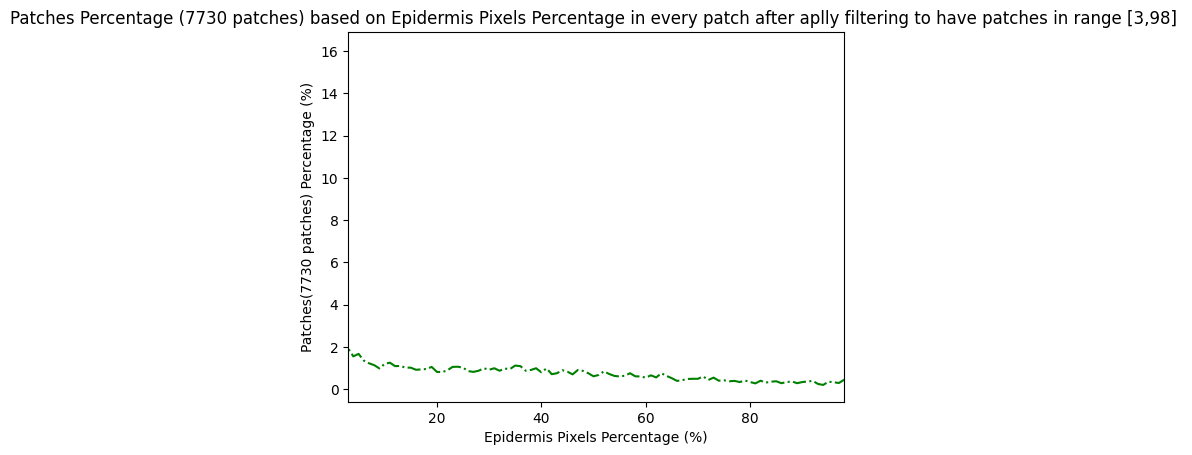

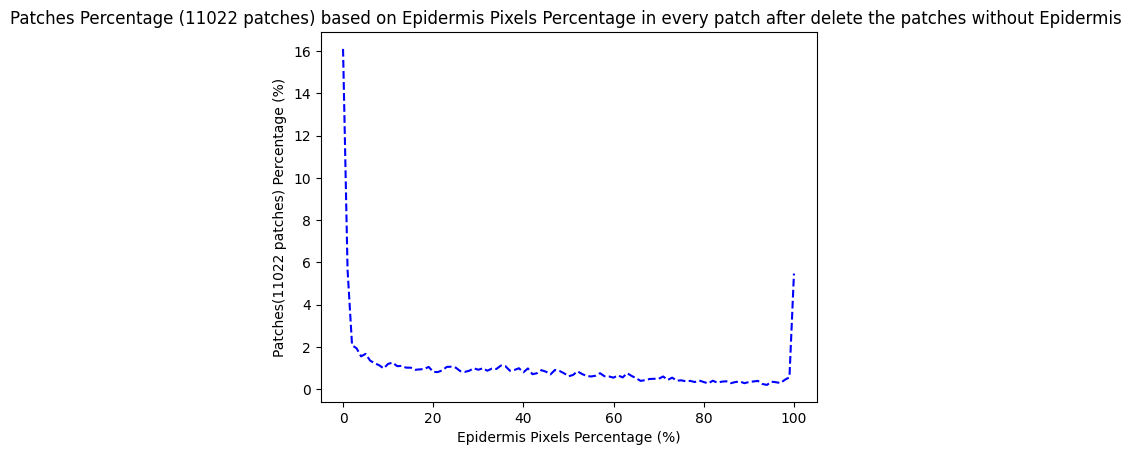

In [10]:
(epi_min,epi_max) = df_filtered['epidermis_percentage'].min(),df_filtered['epidermis_percentage'].max()
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df_filtered))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'green',linestyle='-.',ax = ax)
plt.title('Patches Percentage ('+str(len(df_filtered))+f' patches) based on Epidermis Pixels Percentage in every patch after aplly filtering to have patches in range [{int(epi_min)},{int(epi_max)}] ')
ax.set_xlim(epi_min, epi_max)
plt.show()
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'blue',linestyle='--',ax = ax)
plt.title('Patches Percentage ('+str(len(df))+' patches) based on Epidermis Pixels Percentage in every patch after delete the patches without Epidermis ')
plt.show()

In [11]:
def image_generator(dataf, batch_size = 64):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(dataf.index.values, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = [] 

    for idx in batch:

        #get the masks. Note that masks are png files 

        mask = Image.open(dataf.iloc[idx]['mask_fullpath'])

        mask = np.array(mask)

        #preprocess the mask 
        mask[mask == 255] = 1 
        mask[mask == 0 ] = 0
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(dataf.iloc[idx]['img_fullpath'])
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)

In [12]:
batch_size = 128



train_df, val_df = train_test_split(df_filtered, test_size=0.2)
train_df.index = range(len(train_df))
val_df.index = range(len(val_df))


train_generator = image_generator(train_df, batch_size = batch_size)
val_generator  = image_generator(val_df, batch_size = batch_size)

In [37]:
x, y= next(train_generator)

In [ ]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [40]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [16]:
def unet(sz = (512, 512, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 2
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [41]:
model = unet()

In [43]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',np.round(logs.get('loss'),4),'val_loss=',np.round(logs.get('val_loss'),4),'mean_iou=',np.round(logs.get('mean_iou'),4),'val_mean_iou=',np.round(logs.get('val_mean_iou'),4))
        
        #choose a random test image and preprocess
        j = np.random.choice(val_df.index.values)
        raw = Image.open(val_df.iloc[j]['img_fullpath'])
        ground_truth = Image.open(val_df.iloc[j]['mask_fullpath'])
        raw = np.array(raw.resize((512, 512)))/255.
        ground_truth = np.array(ground_truth.resize((512, 512)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        pred_msk  = pred.squeeze()
        pred_msk = np.stack((pred_msk,)*3, axis=-1)
        
        pred_msk[pred_msk >= 0.5] = 1 
        pred_msk[pred_msk < 0.5] = 0 
        
        ground_truth = np.stack((ground_truth,)*3, axis=-1)
        #show the mask and the segmented image 
        
        combined = np.concatenate([raw, pred_msk, raw* pred_msk,raw*ground_truth], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

/tmp/ipykernel_164/3376737864.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


i= 1 loss= 0.6476 val_loss= 0.6273 mean_iou= 0.0058 val_mean_iou= 0.0026
1/1 [==============================] - 0s 408ms/step


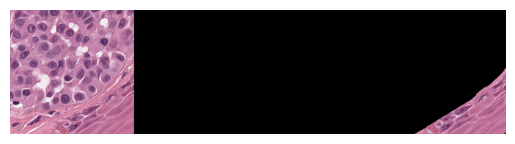

i= 2 loss= 0.6095 val_loss= 0.5607 mean_iou= 0.0116 val_mean_iou= 0.0693
1/1 [==============================] - 0s 97ms/step


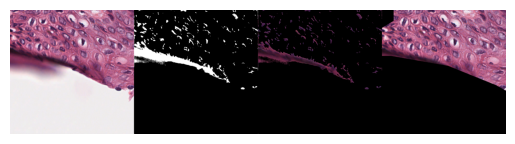

i= 3 loss= 0.5312 val_loss= 0.4903 mean_iou= 0.3289 val_mean_iou= 0.4888
1/1 [==============================] - 0s 106ms/step


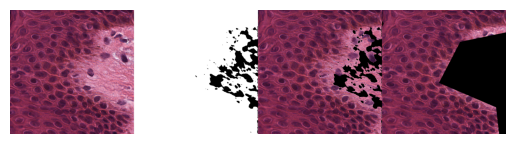

i= 4 loss= 0.5079 val_loss= 0.4926 mean_iou= 0.5398 val_mean_iou= 0.5205
1/1 [==============================] - 0s 101ms/step


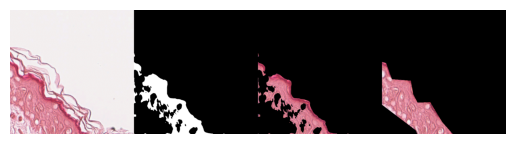

i= 5 loss= 0.4946 val_loss= 0.473 mean_iou= 0.566 val_mean_iou= 0.5829
1/1 [==============================] - 0s 100ms/step


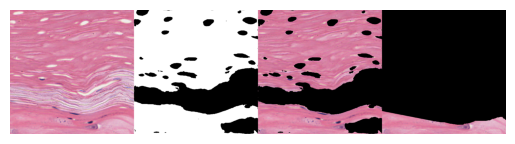

i= 6 loss= 0.4892 val_loss= 0.5173 mean_iou= 0.5677 val_mean_iou= 0.4521
1/1 [==============================] - 0s 107ms/step


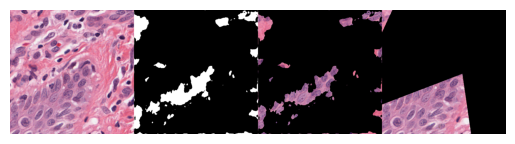

i= 7 loss= 0.4743 val_loss= 0.4553 mean_iou= 0.5703 val_mean_iou= 0.5383
1/1 [==============================] - 0s 103ms/step


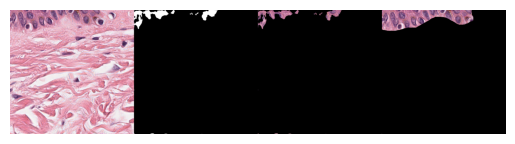

i= 8 loss= 0.4758 val_loss= 0.4579 mean_iou= 0.5898 val_mean_iou= 0.5933
1/1 [==============================] - 0s 101ms/step


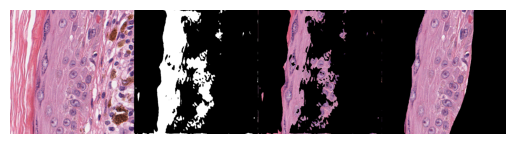

i= 9 loss= 0.4682 val_loss= 0.5232 mean_iou= 0.5928 val_mean_iou= 0.5622
1/1 [==============================] - 0s 100ms/step


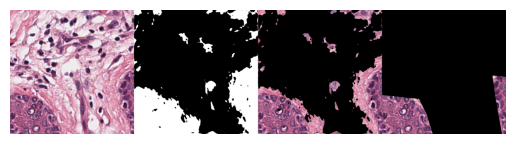

i= 10 loss= 0.4558 val_loss= 0.4398 mean_iou= 0.6044 val_mean_iou= 0.6019
1/1 [==============================] - 0s 103ms/step


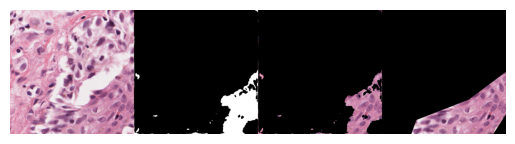

i= 11 loss= 0.451 val_loss= 0.4345 mean_iou= 0.6069 val_mean_iou= 0.6235
1/1 [==============================] - 0s 103ms/step


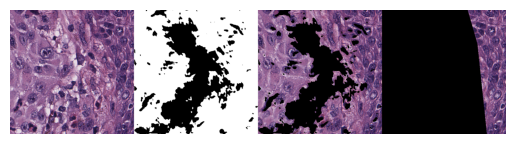

i= 12 loss= 0.4472 val_loss= 0.4403 mean_iou= 0.6083 val_mean_iou= 0.5465
1/1 [==============================] - 0s 104ms/step


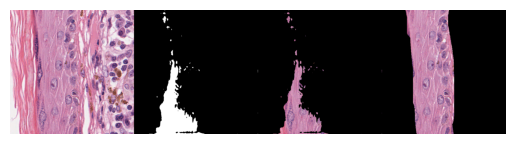

i= 13 loss= 0.4415 val_loss= 0.4185 mean_iou= 0.6178 val_mean_iou= 0.6003
1/1 [==============================] - 0s 122ms/step


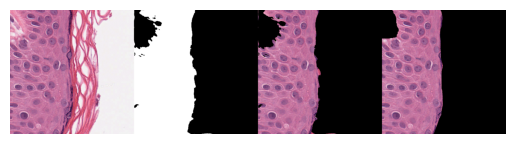

i= 14 loss= 0.4287 val_loss= 0.4331 mean_iou= 0.6228 val_mean_iou= 0.6033
1/1 [==============================] - 0s 101ms/step


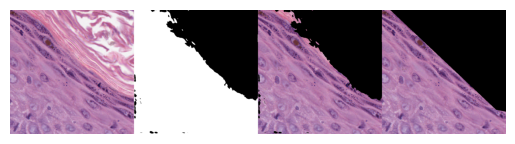

i= 15 loss= 0.4341 val_loss= 0.414 mean_iou= 0.6163 val_mean_iou= 0.6376
1/1 [==============================] - 0s 112ms/step


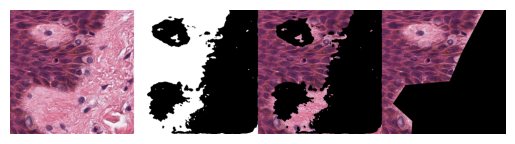

i= 16 loss= 0.4312 val_loss= 0.4131 mean_iou= 0.618 val_mean_iou= 0.622
1/1 [==============================] - 0s 102ms/step


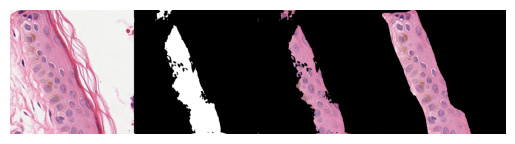

i= 17 loss= 0.4238 val_loss= 0.412 mean_iou= 0.6251 val_mean_iou= 0.6518
1/1 [==============================] - 0s 103ms/step


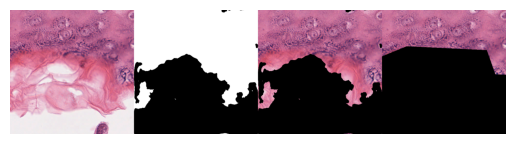

i= 18 loss= 0.4181 val_loss= 0.4371 mean_iou= 0.6344 val_mean_iou= 0.576
1/1 [==============================] - 0s 103ms/step


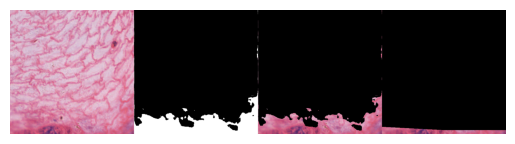

i= 19 loss= 0.4194 val_loss= 0.4306 mean_iou= 0.6276 val_mean_iou= 0.5677
1/1 [==============================] - 0s 98ms/step


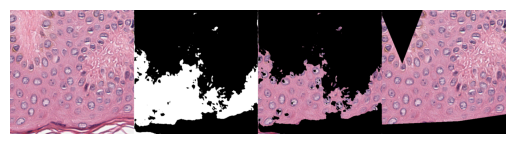

i= 20 loss= 0.4119 val_loss= 0.4528 mean_iou= 0.6394 val_mean_iou= 0.6179
1/1 [==============================] - 0s 100ms/step


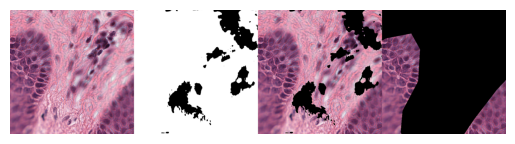

i= 21 loss= 0.409 val_loss= 0.407 mean_iou= 0.6358 val_mean_iou= 0.592
1/1 [==============================] - 0s 102ms/step


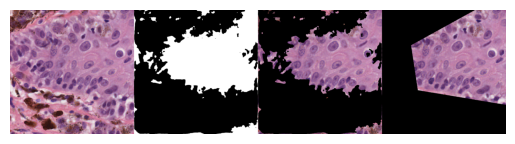

i= 22 loss= 0.404 val_loss= 0.3973 mean_iou= 0.6392 val_mean_iou= 0.6243
1/1 [==============================] - 0s 105ms/step


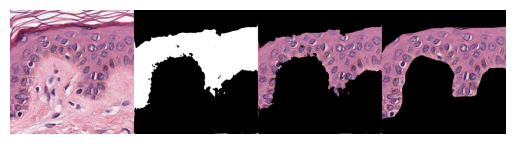

i= 23 loss= 0.3997 val_loss= 0.4173 mean_iou= 0.6449 val_mean_iou= 0.6518
1/1 [==============================] - 0s 102ms/step


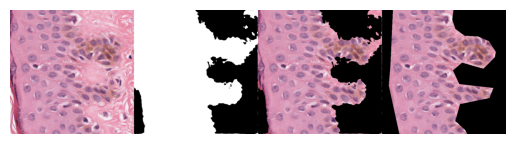

i= 24 loss= 0.4012 val_loss= 0.4084 mean_iou= 0.6437 val_mean_iou= 0.6529
1/1 [==============================] - 0s 104ms/step


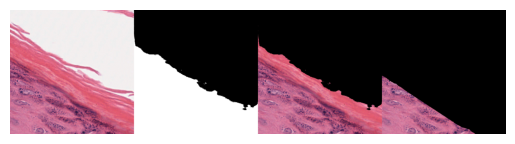

i= 25 loss= 0.3992 val_loss= 0.4103 mean_iou= 0.6465 val_mean_iou= 0.5891
1/1 [==============================] - 0s 98ms/step


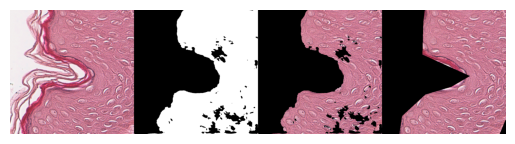

i= 26 loss= 0.3981 val_loss= 0.3843 mean_iou= 0.6406 val_mean_iou= 0.6479
1/1 [==============================] - 0s 110ms/step


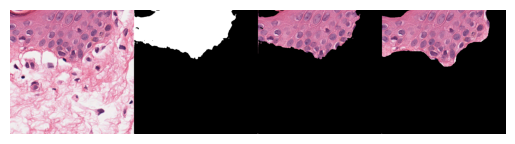

i= 27 loss= 0.3861 val_loss= 0.3872 mean_iou= 0.6525 val_mean_iou= 0.6681
1/1 [==============================] - 0s 97ms/step


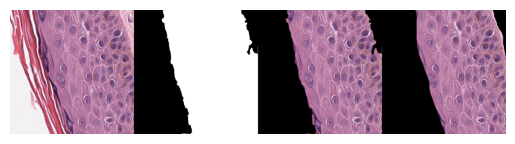

i= 28 loss= 0.3911 val_loss= 0.3755 mean_iou= 0.653 val_mean_iou= 0.6608
1/1 [==============================] - 0s 100ms/step


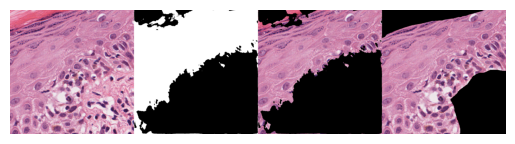

i= 29 loss= 0.3876 val_loss= 0.3768 mean_iou= 0.6492 val_mean_iou= 0.6862
1/1 [==============================] - 0s 97ms/step


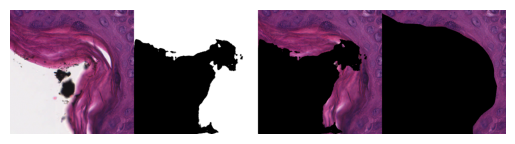

i= 30 loss= 0.3818 val_loss= 0.3821 mean_iou= 0.6569 val_mean_iou= 0.675
1/1 [==============================] - 0s 98ms/step


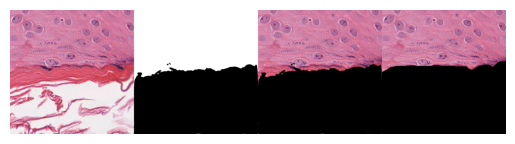

i= 31 loss= 0.3739 val_loss= 0.3704 mean_iou= 0.6692 val_mean_iou= 0.6621
1/1 [==============================] - 0s 103ms/step


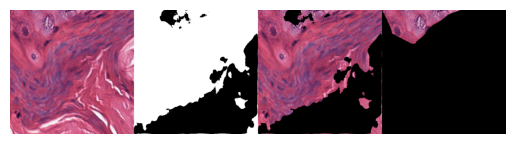

i= 32 loss= 0.374 val_loss= 0.398 mean_iou= 0.663 val_mean_iou= 0.6774
1/1 [==============================] - 0s 102ms/step


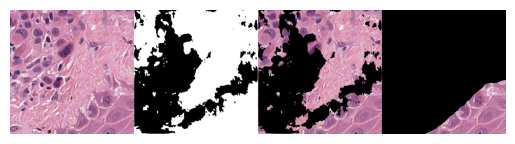

i= 33 loss= 0.3764 val_loss= 0.4321 mean_iou= 0.6582 val_mean_iou= 0.6368
1/1 [==============================] - 0s 107ms/step


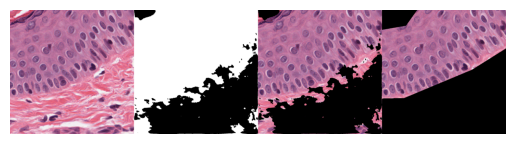

i= 34 loss= 0.3647 val_loss= 0.4025 mean_iou= 0.6737 val_mean_iou= 0.6623
1/1 [==============================] - 0s 103ms/step


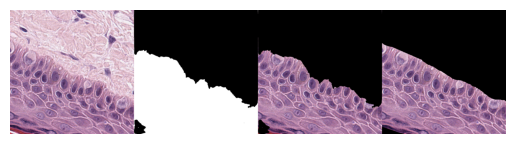

i= 35 loss= 0.3717 val_loss= 0.4082 mean_iou= 0.6705 val_mean_iou= 0.6456
1/1 [==============================] - 0s 105ms/step


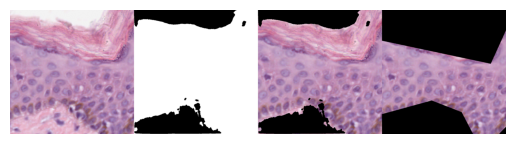

i= 36 loss= 0.3633 val_loss= 0.341 mean_iou= 0.6745 val_mean_iou= 0.6914
1/1 [==============================] - 0s 106ms/step


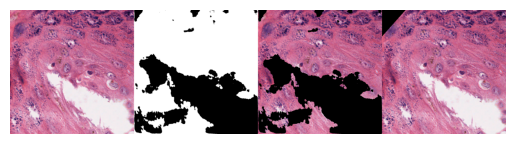

i= 37 loss= 0.35 val_loss= 0.3882 mean_iou= 0.6913 val_mean_iou= 0.6722
1/1 [==============================] - 0s 100ms/step


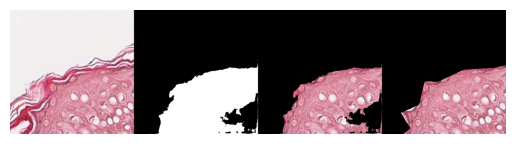

i= 38 loss= 0.3592 val_loss= 0.3684 mean_iou= 0.6818 val_mean_iou= 0.6515
1/1 [==============================] - 0s 103ms/step


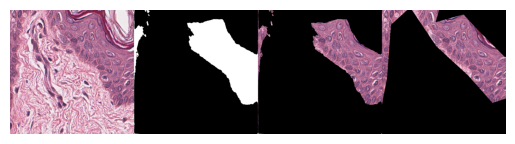

i= 39 loss= 0.348 val_loss= 0.341 mean_iou= 0.6914 val_mean_iou= 0.6925
1/1 [==============================] - 0s 104ms/step


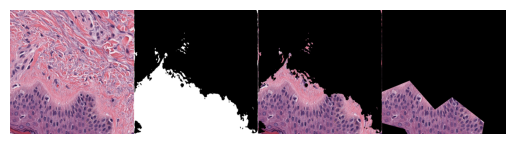

i= 40 loss= 0.342 val_loss= 0.34 mean_iou= 0.7049 val_mean_iou= 0.689
1/1 [==============================] - 0s 99ms/step


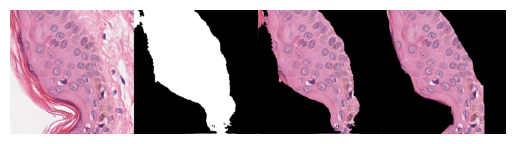

i= 41 loss= 0.3431 val_loss= 0.3277 mean_iou= 0.7008 val_mean_iou= 0.6971
1/1 [==============================] - 0s 105ms/step


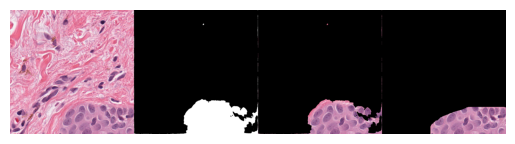

i= 42 loss= 0.3342 val_loss= 0.3355 mean_iou= 0.7076 val_mean_iou= 0.7132
1/1 [==============================] - 0s 104ms/step


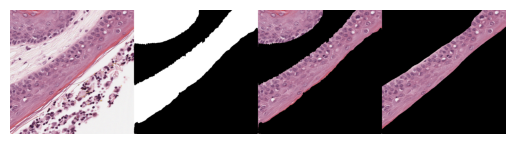

i= 43 loss= 0.3311 val_loss= 0.3577 mean_iou= 0.71 val_mean_iou= 0.656
1/1 [==============================] - 0s 101ms/step


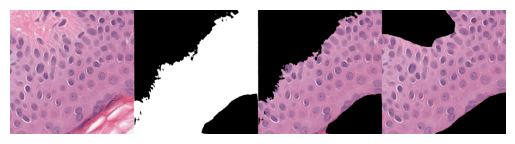

i= 44 loss= 0.3247 val_loss= 0.3219 mean_iou= 0.7143 val_mean_iou= 0.7129
1/1 [==============================] - 0s 103ms/step


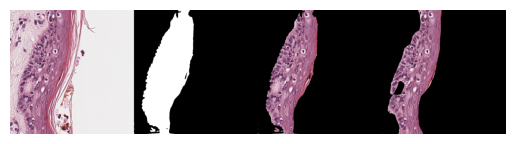

i= 45 loss= 0.3197 val_loss= 0.3158 mean_iou= 0.7189 val_mean_iou= 0.7196
1/1 [==============================] - 0s 97ms/step


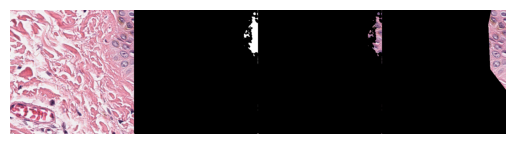

i= 46 loss= 0.3138 val_loss= 0.3129 mean_iou= 0.7308 val_mean_iou= 0.7013
1/1 [==============================] - 0s 104ms/step


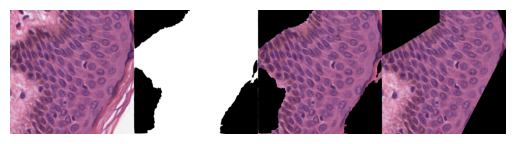

i= 47 loss= 0.3178 val_loss= 0.3001 mean_iou= 0.7236 val_mean_iou= 0.7239
1/1 [==============================] - 0s 98ms/step


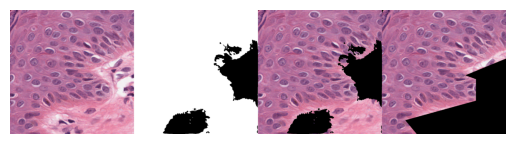

i= 48 loss= 0.3106 val_loss= 0.3343 mean_iou= 0.733 val_mean_iou= 0.7142
1/1 [==============================] - 0s 101ms/step


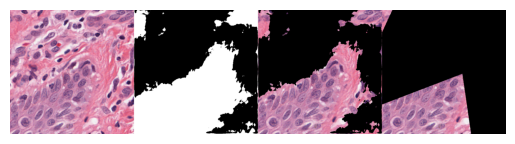

i= 49 loss= 0.3066 val_loss= 0.3041 mean_iou= 0.734 val_mean_iou= 0.7287
1/1 [==============================] - 0s 96ms/step


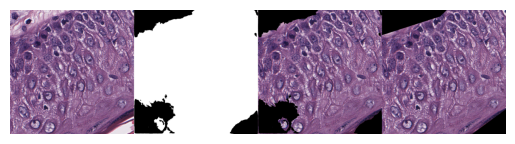

i= 50 loss= 0.308 val_loss= 0.2937 mean_iou= 0.7326 val_mean_iou= 0.7275
1/1 [==============================] - 0s 100ms/step


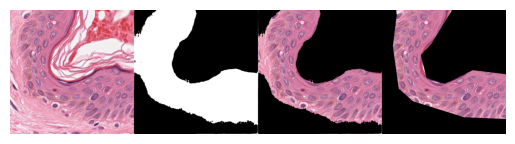

i= 51 loss= 0.2969 val_loss= 0.3088 mean_iou= 0.7472 val_mean_iou= 0.7108
1/1 [==============================] - 0s 104ms/step


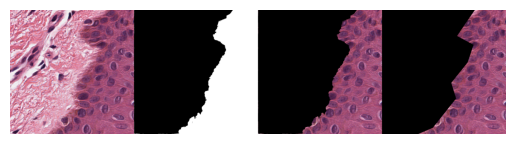

i= 52 loss= 0.2909 val_loss= 0.3668 mean_iou= 0.747 val_mean_iou= 0.6923
1/1 [==============================] - 0s 102ms/step


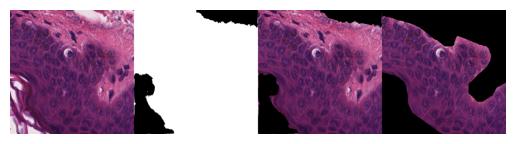

i= 53 loss= 0.294 val_loss= 0.3334 mean_iou= 0.7463 val_mean_iou= 0.6682
1/1 [==============================] - 0s 99ms/step


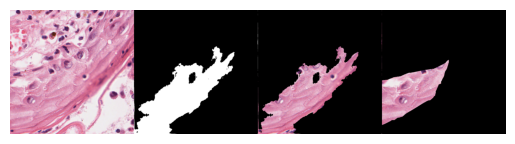

i= 54 loss= 0.2848 val_loss= 0.3442 mean_iou= 0.7559 val_mean_iou= 0.6649
1/1 [==============================] - 0s 104ms/step


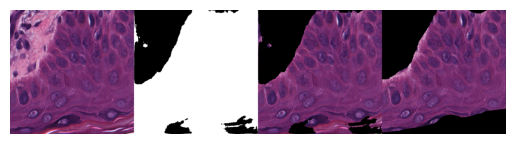

i= 55 loss= 0.2883 val_loss= 0.3345 mean_iou= 0.7538 val_mean_iou= 0.6878
1/1 [==============================] - 0s 108ms/step


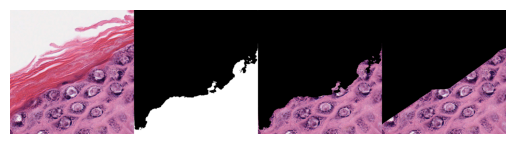

i= 56 loss= 0.2902 val_loss= 0.285 mean_iou= 0.7508 val_mean_iou= 0.7299
1/1 [==============================] - 0s 98ms/step


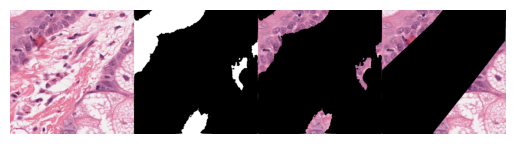

i= 57 loss= 0.2816 val_loss= 0.2993 mean_iou= 0.7582 val_mean_iou= 0.7261
1/1 [==============================] - 0s 96ms/step


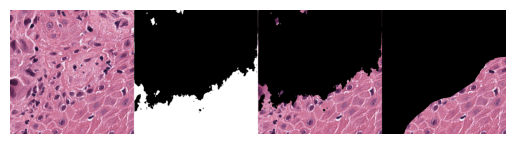

i= 58 loss= 0.2793 val_loss= 0.2679 mean_iou= 0.7554 val_mean_iou= 0.7563
1/1 [==============================] - 0s 102ms/step


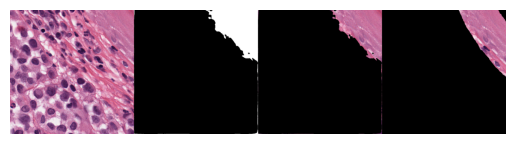

i= 59 loss= 0.2711 val_loss= 0.3151 mean_iou= 0.7637 val_mean_iou= 0.7011
1/1 [==============================] - 0s 98ms/step


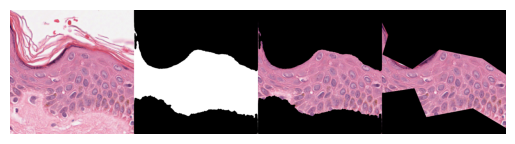

i= 60 loss= 0.2753 val_loss= 0.2646 mean_iou= 0.7617 val_mean_iou= 0.7553
1/1 [==============================] - 0s 98ms/step


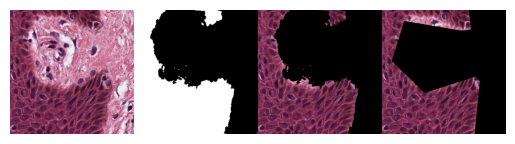

In [44]:
train_steps = len(train_df) //batch_size
val_steps = len(val_df) //batch_size
history = model.fit_generator(train_generator, 
                    epochs = 60, steps_per_epoch = train_steps,validation_data = val_generator, validation_steps = val_steps,
                    callbacks = build_callbacks(), verbose = 0)

In [51]:
model.save('unet_filtered_98-3.h5');

In [52]:
history.history


{'loss': [0.6475949883460999,
  0.6095179915428162,
  0.5312061905860901,
  0.5079209208488464,
  0.4946037828922272,
  0.4892010986804962,
  0.47431817650794983,
  0.47581276297569275,
  0.46819207072257996,
  0.4557788074016571,
  0.4510411322116852,
  0.4472459554672241,
  0.44153523445129395,
  0.42871201038360596,
  0.43409860134124756,
  0.4312115013599396,
  0.4238128662109375,
  0.4181350767612457,
  0.4194059669971466,
  0.41187357902526855,
  0.40902945399284363,
  0.40402939915657043,
  0.39967581629753113,
  0.40115585923194885,
  0.399219274520874,
  0.39810478687286377,
  0.38605669140815735,
  0.39106547832489014,
  0.38760456442832947,
  0.38178133964538574,
  0.3739064037799835,
  0.37404415011405945,
  0.3764148950576782,
  0.3647350072860718,
  0.3716897964477539,
  0.36330029368400574,
  0.3500100374221802,
  0.35919177532196045,
  0.34798988699913025,
  0.3420097529888153,
  0.343095064163208,
  0.3342069089412689,
  0.3310510814189911,
  0.3246768116950989,
  0.31

In [53]:
import json
with open("history_unet_filtered_98-3.json", "w") as outfile:
    json.dump(history.history, outfile)

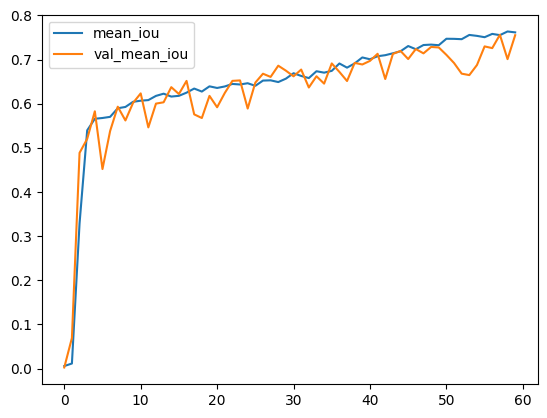

In [54]:
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.legend(['mean_iou', 'val_mean_iou'])
plt.show()

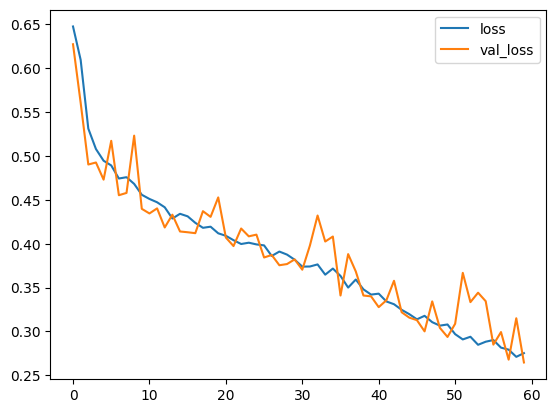

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()